In [3]:
# put download.sh and this notebook in the same folder on google drive. Remember to modify path!
from google.colab import drive
drive.mount('/content/gdrive')

import os

path = "/content/gdrive/MyDrive/DL_Project/Data"
os.chdir(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import librosa
import os
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
#from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import csv
import torch.optim as optim
from tqdm import tqdm
from os.path import exists

# **FEATURE EXTRACTION**

In [5]:
configs = [
    [2048, 512, 2048],
    [2048, 512, 1024],
    [2048, 1024, 1024],
    [1024, 512, 1024],
    [1024, 256, 1024]
]

def process_data(personality_dir="Personality_Scores", metadata_dir="Metadata", audio_dir="Audio_clips"):
    df_personality = get_personality_scores(personality_dir)
    df_metadata = get_metadata(metadata_dir)
    df_feature = get_features(audio_dir)
    
    df = pd.merge(df_personality, df_metadata, left_on="Clip_ID", right_on="Clip_ID")
    df = pd.merge(df, df_feature, left_on="Clip_ID", right_on="Clip_ID")
    
    return df

def get_personality_scores(data_dir_path):
    df = pd.read_csv(data_dir_path + "/Score_011.csv")

    for i in range(1, 11):
        df_tmp = pd.read_csv(data_dir_path + f"/Score_0{i:02d}.csv")
        
        df["Extraversion"] = df["Extraversion"] + df_tmp["Extraversion"]
        df["Agreeableness"] = df["Agreeableness"] + df_tmp["Agreeableness"]
        df["Conscientiousness"] = df["Conscientiousness"] + df_tmp["Conscientiousness"]
        df["Neuroticism"] = df["Neuroticism"] + df_tmp["Neuroticism"]
        df["Openness"] = df["Openness"] + df_tmp["Openness"]

    df["Extraversion"] = df["Extraversion"] / 11
    df["Agreeableness"] = df["Agreeableness"] / 11
    df["Conscientiousness"] = df["Conscientiousness"] / 11
    df["Neuroticism"] = df["Neuroticism"] / 11
    df["Openness"] = df["Openness"] / 11
    
    return df

def get_metadata(data_dir_path):
    df = pd.read_csv(data_dir_path + "/Metadata.csv")
    return df

def get_features(data_dir_path):
    data = []
    
    for filename in os.listdir(data_dir_path):
        f = os.path.join(data_dir_path, filename)
        
        y, sr = librosa.load(f)
        output = []
        pad_len = 0
        for config in configs:
            s = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=config[0], hop_length=config[1], win_length=config[2])
            pad_len = max(pad_len, len(s[0]))
            output.append(s)
        
        for i, cur in enumerate(output):
            cur = np.pad(cur, ((0,0), (0, pad_len-len(cur[0]))))
            output[i] = cur
        output = np.array(output)

        data.append([filename.split(".")[0], output])
    
    df = pd.DataFrame(data, columns=["Clip_ID", "features"])
    return df


In [6]:
!pip3 install pickle5
import pickle5 as pickle

     |████████████████████████████████| 256 kB 14.4 MB/s 


In [7]:
if exists("./processed_data.pkl"):
  with open("./processed_data.pkl", 'rb') as f:
    data = pickle.load(f)
else:
  ! bash download.sh
  data = process_data()
  data.to_pickle("processed_data.pkl")

# **HYPER PARAMETERS**

In [8]:
agg_type = 'numerical'
features = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']

if agg_type == 'numerical':
    agg = ''
else:
    agg = '_categorical'

batch_size = 16
lr = 1e-3
epochs = 200

# **DATA LOADER**

In [9]:
if agg_type=='numerical':
    cutoff = 0
    data['Extraversion'] = np.where(data['Extraversion'] > cutoff,1,0)
    data['Agreeableness'] = np.where(data['Agreeableness'] > cutoff,1,0)
    data['Conscientiousness'] = np.where(data['Conscientiousness'] > cutoff,1,0)
    data['Neuroticism'] = np.where(data['Neuroticism'] > cutoff,1,0)
    data['Openness'] = np.where(data['Openness'] > cutoff,1,0)


In [10]:
#Split dataframe into train, validation, and test sets
train, val, test = np.split(
    data.sample(frac=1, random_state=101),
    [int(.7*len(data)), int(.85*len(data))]
)

In [11]:

class LibriSamplesTrain(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe.index)
    
    def __getitem__(self, ind):
        X = torch.Tensor(np.array(self.dataframe['features'].iloc[ind])) # 5 * 128 * T
        X = X.T # T * 128 * 5

        ys = [self.dataframe[f].iloc[ind] for f in features]
        Y = torch.Tensor(np.array(ys)) # 5
        return X, Y

    def collate_fn(batch):
        batch_x = [x for x,y in batch] # (B * T * 128 * 5)
        batch_y = [y for x,y in batch] # (B * 5)
        lengths_x = [x.shape[0] for x in batch_x]
        batch_x_pad = pad_sequence(batch_x, batch_first=True) # B, T(max time dimension in the batch), 128, 5
        
        lengths_y = [y.shape[0] for y in batch_y] 
        batch_y_pad = pad_sequence(batch_y, batch_first=True) # B * 5

        return batch_x_pad, batch_y_pad, torch.Tensor(lengths_x), torch.Tensor(lengths_y)

class LibriSamplesTest(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe.index)
    
    def __getitem__(self, ind):
        X = torch.Tensor(np.array(self.dataframe['features'].iloc[ind])) # T * 128 * 5
        return X

    def collate_fn(batch):
        batch_x = [x for x,y in batch] # (B * T * 128 * 5)

        lengths_x = [x.shape[0] for x in batch_x]
        batch_x_pad = pad_sequence(batch_x, batch_first=True) # B, T(max time dimension in the batch), 128, 5

        return batch_x_pad, torch.Tensor(lengths_x)


In [12]:
train_data = LibriSamplesTrain(train)
val_data = LibriSamplesTrain(val)
test_data = LibriSamplesTest(test)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True, collate_fn = LibriSamplesTrain.collate_fn)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, shuffle=False, collate_fn = LibriSamplesTrain.collate_fn) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle=False, collate_fn = LibriSamplesTest.collate_fn) 

print("Batch size: ", batch_size)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  16
Train dataset samples = 448, batches = 28
Val dataset samples = 96, batches = 6
Test dataset samples = 96, batches = 6


# **MODEL**

In [13]:
class Network(nn.Module):

    def __init__(self):

        super(Network, self).__init__()
        
        self.embedding = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.AvgPool2d((3, 3)),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.GELU(),
            nn.AvgPool2d((3, 3))
        )

        self.flatten = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

        self.classification = nn.Sequential(
            nn.Linear(512, 2048),
            nn.BatchNorm1d(2048),
            nn.GELU(),
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout2d(0.3),
            nn.Linear(512, 5),
        )

    def forward(self, x):      
        x = x.transpose(1, 3) # B * 5 * 128 * T 
        out = self.embedding(x) # B * 512 * H * W (H and W are from CNN)
        out = self.flatten(out) # B * 512 * 1
        out = self.classification(out) # B * num_class
        out = torch.sigmoid(out)
        return out

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Network().to(device)
print(model)

Network(
  (embedding): Sequential(
    (0): Conv2d(5, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU()
    (3): AvgPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GELU()
    (7): Dropout2d(p=0.2, inplace=False)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): GELU()
    (11): AvgPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0)
  )
  (flatten): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(1, 1))
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (classification): Sequential(
    (0): Linear(in_features=512, out_features=2048, bi

In [15]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=5e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.5)

# **TRAIN**

In [16]:
train_acc_list = list()
train_loss_list = list()
lr_list = list()
validation_acc_list = list()

train_separate_acc_list = list()
val_separate_acc_list = list()


print('train_loader: ', len(train_loader))


for epoch in range(epochs):

    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 
    total_loss = 0
    train_num_correct =0

    #train_separate_acc = 0
    train_separate_count = [0]*5


    #train
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() 

        x, y, xlens, ylens = data
        x = x.to(device)
        y = y.to(device)

        output=model(x)
        prediction_out = (output>0.5).float()


        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
        train_num_correct += int((prediction_out==y).sum())
        total_loss += loss.item()
        # print("loss", loss.item())

        for i in range(len(prediction_out)):
            predict, real = prediction_out[i], y[i]
            for j in range(len(predict)):
                if int(predict[j]) == int(real[j]):
                    train_separate_count[j] = train_separate_count[j] + 1



        batch_bar.set_postfix(
          loss="{:.04f}".format(float(total_loss/(i+1)))
        )
        batch_bar.update()

    # torch.cuda.empty_cache()

    # validate
    model.eval()
    batch_bar.close()
    val_num_correct = 0
    val_separate_acc = 0
    val_separate_count = [0]*5

    for i, data in enumerate(val_loader):
        x, y, xlens, ylens = data
        x = x.to(device)
        y = y.to(device)

        val_outputs = model(x)
        prediction_val = (val_outputs>0.5).float()


        cur_count = 0
        for i in range(len(prediction_val)):
            predict, real = prediction_val[i], y[i]
            for j in range(len(predict)):
                if int(predict[j]) == int(real[j]):
                    cur_count += 1
                    val_separate_count[j] = val_separate_count[j] + 1
        
        val_num_correct += cur_count


    # torch.cuda.empty_cache()

    train_acc = 100 * (train_num_correct/5) / (len(train_loader) * batch_size)
    train_loss = float(total_loss / len(train_loader))
    lr = float(optimizer.param_groups[0]['lr'])
    validation_acc = 100 * (val_num_correct/5) / (len(val_loader)*batch_size)
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    lr_list.append(lr)
    validation_acc_list.append(validation_acc)


    train_separate_acc = 100 * np.array(train_separate_count) / (len(train_loader)*batch_size)
    train_separate_acc_list.append(train_separate_acc)


    val_separate_acc = 100 * np.array(val_separate_count) / (len(val_loader)*batch_size)
    val_separate_acc_list.append(val_separate_acc)


    
    #train_loss = float(total_loss / len(train_loader))
    #lr = float(optimizer.param_groups[0]['lr'])
    #validation_acc = 100 * val_num_correct / (len(val_loader)*batch_size)


    
    #train_loss_list.append(train_loss)
    #lr_list.append(lr)
    #validation_acc_list.append(validation_acc)


    print("Epoch {}/{}: Train Acc {:.04f}%, Train Loss {}, Learning Rate {}, Val Acc {:.04f}%".format(
        epoch + 1,
        epochs,
        train_acc,
        train_loss,
        lr,
        validation_acc,
        ))
    
    #print(val_separate_acc)
    
    scheduler.step()

train_loader:  28


Train:   0%|          | 0/28 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg

Epoch 1/200: Train Acc 66.4286%, Train Loss 0.6536921411752701, Learning Rate 0.001, Val Acc 72.7083%


Epoch 2/200: Train Acc 71.7411%, Train Loss 0.60543413992439, Learning Rate 0.001, Val Acc 72.9167%


Epoch 3/200: Train Acc 72.0089%, Train Loss 0.6021711081266403, Learning Rate 0.001, Val Acc 71.8750%


Epoch 4/200: Train Acc 73.2143%, Train Loss 0.5798795531902995, Learning Rate 0.001, Val Acc 71.4583%


Epoch 5/200: Train Acc 73.2589%, Train Loss 0.5860255030649049, Learning Rate 0.001, Val Acc 69.7917%


Epoch 6/200: Train Acc 73.9286%, Train Loss 0.5747651234269142, Learning Rate 0.001, Val Acc 70.6250%


Epoch 7/200: Train Acc 72.9464%, Train Loss 0.5694042635815484, Learning Rate 0.001, Val Acc 71.4583%


Epoch 8/200: Train Acc 74.6875%, Train Loss 0.5600262262991497, Learning Rate 0.001, Val Acc 74.1667%


Epoch 9/200: Train Acc 74.5536%, Train Loss 0.5553540342620441, Learning Rate 0.001, Val Acc 70.0000%


Epoch 10/200: Train Acc 74.4196%, Train Loss 0.5770834333130291, Learning Rate 0.001, Val Acc 72.5000%


Epoch 11/200: Train Acc 74.1964%, Train Loss 0.5612484887242317, Learning Rate 0.001, Val Acc 64.3750%


Epoch 12/200: Train Acc 75.5804%, Train Loss 0.5361326496515956, Learning Rate 0.001, Val Acc 73.3333%


Epoch 13/200: Train Acc 75.0000%, Train Loss 0.5472360189471926, Learning Rate 0.001, Val Acc 71.8750%


Epoch 14/200: Train Acc 75.0446%, Train Loss 0.5218779572418758, Learning Rate 0.001, Val Acc 74.5833%


Epoch 15/200: Train Acc 76.0268%, Train Loss 0.532576108617442, Learning Rate 0.001, Val Acc 73.5417%


Epoch 16/200: Train Acc 75.4464%, Train Loss 0.5397166396890368, Learning Rate 0.001, Val Acc 73.9583%


Epoch 17/200: Train Acc 75.8036%, Train Loss 0.5318755166871207, Learning Rate 0.001, Val Acc 74.1667%


Epoch 18/200: Train Acc 76.0268%, Train Loss 0.529959394463471, Learning Rate 0.001, Val Acc 71.0417%


Epoch 19/200: Train Acc 75.3571%, Train Loss 0.5262326108557838, Learning Rate 0.001, Val Acc 75.4167%


Epoch 20/200: Train Acc 76.2054%, Train Loss 0.512140052659171, Learning Rate 0.001, Val Acc 74.7917%


Epoch 21/200: Train Acc 77.4107%, Train Loss 0.49627253093889784, Learning Rate 0.0005, Val Acc 68.5417%


Epoch 22/200: Train Acc 77.5000%, Train Loss 0.49445799205984386, Learning Rate 0.0005, Val Acc 69.7917%


Epoch 23/200: Train Acc 77.3661%, Train Loss 0.5057229718991688, Learning Rate 0.0005, Val Acc 75.0000%


Epoch 24/200: Train Acc 77.1429%, Train Loss 0.5015277223927634, Learning Rate 0.0005, Val Acc 66.2500%


Epoch 25/200: Train Acc 76.6964%, Train Loss 0.5019034828458514, Learning Rate 0.0005, Val Acc 64.7917%


Epoch 26/200: Train Acc 77.7232%, Train Loss 0.49528932677848, Learning Rate 0.0005, Val Acc 73.7500%


Epoch 27/200: Train Acc 77.4554%, Train Loss 0.49630230984517504, Learning Rate 0.0005, Val Acc 74.5833%


Epoch 28/200: Train Acc 77.2768%, Train Loss 0.4727020636200905, Learning Rate 0.0005, Val Acc 60.6250%


Epoch 29/200: Train Acc 77.9464%, Train Loss 0.4949481359549931, Learning Rate 0.0005, Val Acc 75.2083%


Epoch 30/200: Train Acc 79.1964%, Train Loss 0.464746182518346, Learning Rate 0.0005, Val Acc 73.9583%


Epoch 31/200: Train Acc 77.0536%, Train Loss 0.48803183329956873, Learning Rate 0.0005, Val Acc 74.3750%


Epoch 32/200: Train Acc 77.7232%, Train Loss 0.4885671692235129, Learning Rate 0.0005, Val Acc 72.2917%


Epoch 33/200: Train Acc 77.6339%, Train Loss 0.485528863966465, Learning Rate 0.0005, Val Acc 61.2500%


Epoch 34/200: Train Acc 79.0625%, Train Loss 0.46247768295662744, Learning Rate 0.0005, Val Acc 73.7500%


Epoch 35/200: Train Acc 79.2411%, Train Loss 0.4650876671075821, Learning Rate 0.0005, Val Acc 68.9583%


Epoch 36/200: Train Acc 79.1964%, Train Loss 0.4522663014275687, Learning Rate 0.0005, Val Acc 73.9583%


Epoch 37/200: Train Acc 79.4643%, Train Loss 0.4759994532380785, Learning Rate 0.0005, Val Acc 74.3750%


Epoch 38/200: Train Acc 77.8571%, Train Loss 0.47846824462924686, Learning Rate 0.0005, Val Acc 74.7917%


Epoch 39/200: Train Acc 78.5268%, Train Loss 0.47017480965171543, Learning Rate 0.0005, Val Acc 65.4167%


Epoch 40/200: Train Acc 79.1964%, Train Loss 0.45855408906936646, Learning Rate 0.0005, Val Acc 66.6667%


Epoch 41/200: Train Acc 78.5268%, Train Loss 0.46176312544516157, Learning Rate 0.00025, Val Acc 75.4167%


Epoch 42/200: Train Acc 78.9286%, Train Loss 0.4549393228122166, Learning Rate 0.00025, Val Acc 66.4583%


Epoch 43/200: Train Acc 80.1339%, Train Loss 0.43853084317275454, Learning Rate 0.00025, Val Acc 76.0417%


Epoch 44/200: Train Acc 79.4196%, Train Loss 0.44864971722875324, Learning Rate 0.00025, Val Acc 71.0417%


Epoch 45/200: Train Acc 78.7946%, Train Loss 0.44137538011584965, Learning Rate 0.00025, Val Acc 67.0833%


Epoch 46/200: Train Acc 79.0179%, Train Loss 0.45092556519167765, Learning Rate 0.00025, Val Acc 76.0417%


Epoch 47/200: Train Acc 80.2679%, Train Loss 0.43110377554382595, Learning Rate 0.00025, Val Acc 68.7500%


Epoch 48/200: Train Acc 80.6250%, Train Loss 0.42713737381356104, Learning Rate 0.00025, Val Acc 76.2500%


Epoch 49/200: Train Acc 80.5804%, Train Loss 0.43215252991233555, Learning Rate 0.00025, Val Acc 71.2500%


Epoch 50/200: Train Acc 79.9554%, Train Loss 0.4288835461650576, Learning Rate 0.00025, Val Acc 72.0833%


Epoch 51/200: Train Acc 80.0000%, Train Loss 0.4413421569125993, Learning Rate 0.00025, Val Acc 65.2083%


Epoch 52/200: Train Acc 81.3839%, Train Loss 0.41380096652678083, Learning Rate 0.00025, Val Acc 62.9167%


Epoch 53/200: Train Acc 81.5625%, Train Loss 0.4271644556096622, Learning Rate 0.00025, Val Acc 70.6250%


Epoch 54/200: Train Acc 80.6250%, Train Loss 0.4235686787537166, Learning Rate 0.00025, Val Acc 64.1667%


Epoch 55/200: Train Acc 79.2411%, Train Loss 0.4448254480957985, Learning Rate 0.00025, Val Acc 73.3333%


Epoch 56/200: Train Acc 79.8214%, Train Loss 0.4258087266768728, Learning Rate 0.00025, Val Acc 73.9583%


Epoch 57/200: Train Acc 80.2232%, Train Loss 0.43264514420713696, Learning Rate 0.00025, Val Acc 62.5000%


Epoch 58/200: Train Acc 79.4196%, Train Loss 0.42019146255084444, Learning Rate 0.00025, Val Acc 75.0000%


Epoch 59/200: Train Acc 81.4286%, Train Loss 0.4195661906685148, Learning Rate 0.00025, Val Acc 72.7083%


Epoch 60/200: Train Acc 81.2500%, Train Loss 0.41190011160714285, Learning Rate 0.00025, Val Acc 51.0417%


Epoch 61/200: Train Acc 81.2054%, Train Loss 0.40225660162312643, Learning Rate 0.000125, Val Acc 71.8750%


Epoch 62/200: Train Acc 82.5000%, Train Loss 0.39405731005328043, Learning Rate 0.000125, Val Acc 62.2917%


Epoch 63/200: Train Acc 82.1429%, Train Loss 0.3986947823848043, Learning Rate 0.000125, Val Acc 71.6667%


Epoch 64/200: Train Acc 81.5179%, Train Loss 0.407440256859575, Learning Rate 0.000125, Val Acc 74.7917%


Epoch 65/200: Train Acc 83.3036%, Train Loss 0.3922981641122273, Learning Rate 0.000125, Val Acc 70.8333%


Epoch 66/200: Train Acc 83.2589%, Train Loss 0.37701952776738573, Learning Rate 0.000125, Val Acc 71.4583%


Epoch 67/200: Train Acc 82.4107%, Train Loss 0.4065974514399256, Learning Rate 0.000125, Val Acc 69.1667%


Epoch 68/200: Train Acc 82.0982%, Train Loss 0.38919111234801157, Learning Rate 0.000125, Val Acc 73.1250%


Epoch 69/200: Train Acc 82.8571%, Train Loss 0.3903147924159254, Learning Rate 0.000125, Val Acc 73.5417%


Epoch 70/200: Train Acc 82.9911%, Train Loss 0.39077692691768917, Learning Rate 0.000125, Val Acc 67.5000%


Epoch 71/200: Train Acc 83.3036%, Train Loss 0.3779456972011498, Learning Rate 0.000125, Val Acc 73.3333%


Epoch 72/200: Train Acc 83.5714%, Train Loss 0.3725556528994015, Learning Rate 0.000125, Val Acc 69.1667%


Epoch 73/200: Train Acc 82.9911%, Train Loss 0.3858058729342052, Learning Rate 0.000125, Val Acc 69.3750%


Epoch 74/200: Train Acc 81.8750%, Train Loss 0.3971034831234387, Learning Rate 0.000125, Val Acc 70.0000%


Epoch 75/200: Train Acc 82.7679%, Train Loss 0.37655990038599285, Learning Rate 0.000125, Val Acc 63.3333%


Epoch 76/200: Train Acc 82.2321%, Train Loss 0.38320325527872356, Learning Rate 0.000125, Val Acc 76.2500%


Epoch 77/200: Train Acc 82.0536%, Train Loss 0.3923474220292909, Learning Rate 0.000125, Val Acc 71.2500%


Epoch 78/200: Train Acc 84.5536%, Train Loss 0.35458708820598467, Learning Rate 0.000125, Val Acc 66.8750%


Epoch 79/200: Train Acc 83.7946%, Train Loss 0.36617977704320637, Learning Rate 0.000125, Val Acc 69.1667%


Epoch 80/200: Train Acc 83.3482%, Train Loss 0.37740953852023396, Learning Rate 0.000125, Val Acc 61.0417%


Epoch 81/200: Train Acc 84.5536%, Train Loss 0.36536636682493345, Learning Rate 6.25e-05, Val Acc 72.0833%


Epoch 82/200: Train Acc 82.7232%, Train Loss 0.3785854647202151, Learning Rate 6.25e-05, Val Acc 64.7917%


Epoch 83/200: Train Acc 84.1071%, Train Loss 0.37123226693698336, Learning Rate 6.25e-05, Val Acc 65.2083%


Epoch 84/200: Train Acc 82.9911%, Train Loss 0.3640613151448114, Learning Rate 6.25e-05, Val Acc 71.6667%


Epoch 85/200: Train Acc 83.8393%, Train Loss 0.36728724411555697, Learning Rate 6.25e-05, Val Acc 76.0417%


Epoch 86/200: Train Acc 85.2232%, Train Loss 0.348808228969574, Learning Rate 6.25e-05, Val Acc 73.5417%


Epoch 87/200: Train Acc 84.1518%, Train Loss 0.3687654510140419, Learning Rate 6.25e-05, Val Acc 66.6667%


Epoch 88/200: Train Acc 84.9554%, Train Loss 0.3552681750484875, Learning Rate 6.25e-05, Val Acc 73.3333%


Epoch 89/200: Train Acc 85.1339%, Train Loss 0.33941359392234255, Learning Rate 6.25e-05, Val Acc 63.5417%


Epoch 90/200: Train Acc 84.5089%, Train Loss 0.35720608276980265, Learning Rate 6.25e-05, Val Acc 72.9167%


Epoch 91/200: Train Acc 84.1071%, Train Loss 0.3555721039218562, Learning Rate 6.25e-05, Val Acc 71.4583%


Epoch 92/200: Train Acc 84.5982%, Train Loss 0.36159717930214746, Learning Rate 6.25e-05, Val Acc 73.3333%


Epoch 93/200: Train Acc 86.1607%, Train Loss 0.33704694945897373, Learning Rate 6.25e-05, Val Acc 68.7500%


Epoch 94/200: Train Acc 84.5982%, Train Loss 0.35869660920330454, Learning Rate 6.25e-05, Val Acc 70.2083%


Epoch 95/200: Train Acc 85.8036%, Train Loss 0.33406422500099453, Learning Rate 6.25e-05, Val Acc 70.4167%


Epoch 96/200: Train Acc 84.7321%, Train Loss 0.3567113312227385, Learning Rate 6.25e-05, Val Acc 71.6667%


Epoch 97/200: Train Acc 85.4018%, Train Loss 0.35026748531631063, Learning Rate 6.25e-05, Val Acc 74.3750%


Epoch 98/200: Train Acc 84.9107%, Train Loss 0.34271286374756266, Learning Rate 6.25e-05, Val Acc 72.0833%


Epoch 99/200: Train Acc 85.4911%, Train Loss 0.3270952483373029, Learning Rate 6.25e-05, Val Acc 66.2500%


Epoch 100/200: Train Acc 86.0714%, Train Loss 0.33880405287657467, Learning Rate 6.25e-05, Val Acc 74.5833%


Epoch 101/200: Train Acc 85.4018%, Train Loss 0.34170753402369364, Learning Rate 3.125e-05, Val Acc 67.5000%


Epoch 102/200: Train Acc 86.1161%, Train Loss 0.32451553429876057, Learning Rate 3.125e-05, Val Acc 72.9167%


Epoch 103/200: Train Acc 85.3125%, Train Loss 0.3412346914410591, Learning Rate 3.125e-05, Val Acc 75.8333%


Epoch 104/200: Train Acc 84.8661%, Train Loss 0.3472906846020903, Learning Rate 3.125e-05, Val Acc 74.3750%


Epoch 105/200: Train Acc 85.9821%, Train Loss 0.3296468625111239, Learning Rate 3.125e-05, Val Acc 69.3750%


Epoch 106/200: Train Acc 86.2054%, Train Loss 0.3195358637188162, Learning Rate 3.125e-05, Val Acc 72.9167%


Epoch 107/200: Train Acc 86.4286%, Train Loss 0.32379940524697304, Learning Rate 3.125e-05, Val Acc 69.7917%


Epoch 108/200: Train Acc 86.2500%, Train Loss 0.316095125994512, Learning Rate 3.125e-05, Val Acc 71.4583%


Epoch 109/200: Train Acc 86.0268%, Train Loss 0.32628316219363895, Learning Rate 3.125e-05, Val Acc 70.0000%


Epoch 110/200: Train Acc 85.9821%, Train Loss 0.32553683913179804, Learning Rate 3.125e-05, Val Acc 74.3750%


Epoch 111/200: Train Acc 85.8036%, Train Loss 0.3179910512907164, Learning Rate 3.125e-05, Val Acc 75.6250%


Epoch 112/200: Train Acc 87.3214%, Train Loss 0.31607627496123314, Learning Rate 3.125e-05, Val Acc 73.1250%


Epoch 113/200: Train Acc 87.5446%, Train Loss 0.3149735523121698, Learning Rate 3.125e-05, Val Acc 72.2917%


Epoch 114/200: Train Acc 85.6250%, Train Loss 0.32815865320818766, Learning Rate 3.125e-05, Val Acc 72.0833%


Epoch 115/200: Train Acc 85.5804%, Train Loss 0.3268891940159457, Learning Rate 3.125e-05, Val Acc 72.0833%


Epoch 116/200: Train Acc 87.3661%, Train Loss 0.29611485291804585, Learning Rate 3.125e-05, Val Acc 70.6250%


Epoch 117/200: Train Acc 87.4554%, Train Loss 0.3031073191336223, Learning Rate 3.125e-05, Val Acc 73.7500%


Epoch 118/200: Train Acc 86.2054%, Train Loss 0.30779613288385527, Learning Rate 3.125e-05, Val Acc 69.1667%


Epoch 119/200: Train Acc 87.7679%, Train Loss 0.3106008784047195, Learning Rate 3.125e-05, Val Acc 73.9583%


Epoch 120/200: Train Acc 87.1429%, Train Loss 0.3209101600306375, Learning Rate 3.125e-05, Val Acc 72.2917%


Epoch 121/200: Train Acc 86.0714%, Train Loss 0.3205187251525266, Learning Rate 1.5625e-05, Val Acc 73.5417%


Epoch 122/200: Train Acc 86.2500%, Train Loss 0.3169871079070227, Learning Rate 1.5625e-05, Val Acc 74.1667%


Epoch 123/200: Train Acc 87.0089%, Train Loss 0.3120820511664663, Learning Rate 1.5625e-05, Val Acc 73.3333%


Epoch 124/200: Train Acc 84.6875%, Train Loss 0.3266489346112524, Learning Rate 1.5625e-05, Val Acc 73.9583%


Epoch 125/200: Train Acc 85.0000%, Train Loss 0.32938086507575853, Learning Rate 1.5625e-05, Val Acc 71.8750%


Epoch 126/200: Train Acc 87.0982%, Train Loss 0.29933826731784, Learning Rate 1.5625e-05, Val Acc 73.7500%


Epoch 127/200: Train Acc 86.6071%, Train Loss 0.31402279809117317, Learning Rate 1.5625e-05, Val Acc 74.3750%


Epoch 128/200: Train Acc 86.3839%, Train Loss 0.30072313972881864, Learning Rate 1.5625e-05, Val Acc 73.9583%


Epoch 129/200: Train Acc 86.3839%, Train Loss 0.3251207449606487, Learning Rate 1.5625e-05, Val Acc 75.0000%


Epoch 130/200: Train Acc 85.9375%, Train Loss 0.32024215693984714, Learning Rate 1.5625e-05, Val Acc 74.7917%


Epoch 131/200: Train Acc 86.4732%, Train Loss 0.3227842998291765, Learning Rate 1.5625e-05, Val Acc 73.3333%


Epoch 132/200: Train Acc 86.2500%, Train Loss 0.3281523824802467, Learning Rate 1.5625e-05, Val Acc 74.3750%


Epoch 133/200: Train Acc 85.8482%, Train Loss 0.3168615347572735, Learning Rate 1.5625e-05, Val Acc 72.5000%


Epoch 134/200: Train Acc 87.0089%, Train Loss 0.3109825982579163, Learning Rate 1.5625e-05, Val Acc 75.4167%


Epoch 135/200: Train Acc 86.6071%, Train Loss 0.31382133971367565, Learning Rate 1.5625e-05, Val Acc 72.7083%


Epoch 136/200: Train Acc 85.9375%, Train Loss 0.32346335851720404, Learning Rate 1.5625e-05, Val Acc 73.3333%


Epoch 137/200: Train Acc 86.4732%, Train Loss 0.3012535087764263, Learning Rate 1.5625e-05, Val Acc 72.5000%


Epoch 138/200: Train Acc 87.5000%, Train Loss 0.29746568149753977, Learning Rate 1.5625e-05, Val Acc 75.2083%


Epoch 139/200: Train Acc 86.2946%, Train Loss 0.3124935919685023, Learning Rate 1.5625e-05, Val Acc 74.5833%


Epoch 140/200: Train Acc 86.9643%, Train Loss 0.3190145513841084, Learning Rate 1.5625e-05, Val Acc 74.3750%


Epoch 141/200: Train Acc 86.2946%, Train Loss 0.31637642106839586, Learning Rate 7.8125e-06, Val Acc 73.5417%


Epoch 142/200: Train Acc 86.3393%, Train Loss 0.3154766213681017, Learning Rate 7.8125e-06, Val Acc 74.1667%


Epoch 143/200: Train Acc 86.6964%, Train Loss 0.3138145852301802, Learning Rate 7.8125e-06, Val Acc 74.1667%


Epoch 144/200: Train Acc 86.6964%, Train Loss 0.3059869392641953, Learning Rate 7.8125e-06, Val Acc 74.1667%


Epoch 145/200: Train Acc 87.1429%, Train Loss 0.3029123305210045, Learning Rate 7.8125e-06, Val Acc 74.3750%


Epoch 146/200: Train Acc 87.3661%, Train Loss 0.3137676902115345, Learning Rate 7.8125e-06, Val Acc 74.3750%


Epoch 147/200: Train Acc 86.7857%, Train Loss 0.32369784797940937, Learning Rate 7.8125e-06, Val Acc 73.9583%


Epoch 148/200: Train Acc 86.5179%, Train Loss 0.30476429206984385, Learning Rate 7.8125e-06, Val Acc 73.5417%


Epoch 149/200: Train Acc 86.6071%, Train Loss 0.3069746233522892, Learning Rate 7.8125e-06, Val Acc 74.5833%


Epoch 150/200: Train Acc 86.5625%, Train Loss 0.3181683389203889, Learning Rate 7.8125e-06, Val Acc 74.1667%


Epoch 151/200: Train Acc 87.3214%, Train Loss 0.30040029755660463, Learning Rate 7.8125e-06, Val Acc 73.7500%


Epoch 152/200: Train Acc 87.0536%, Train Loss 0.30270638476525036, Learning Rate 7.8125e-06, Val Acc 74.3750%


Epoch 153/200: Train Acc 86.7857%, Train Loss 0.30136887090546743, Learning Rate 7.8125e-06, Val Acc 74.5833%


Epoch 154/200: Train Acc 87.3214%, Train Loss 0.29881423924650463, Learning Rate 7.8125e-06, Val Acc 75.4167%


Epoch 155/200: Train Acc 88.0357%, Train Loss 0.30328478664159775, Learning Rate 7.8125e-06, Val Acc 73.9583%


Epoch 156/200: Train Acc 87.0089%, Train Loss 0.3152516409754753, Learning Rate 7.8125e-06, Val Acc 73.1250%


Epoch 157/200: Train Acc 87.2768%, Train Loss 0.3015705921820232, Learning Rate 7.8125e-06, Val Acc 74.3750%


Epoch 158/200: Train Acc 86.5179%, Train Loss 0.3001173793205193, Learning Rate 7.8125e-06, Val Acc 74.3750%


Epoch 159/200: Train Acc 85.8036%, Train Loss 0.32417233873690876, Learning Rate 7.8125e-06, Val Acc 74.7917%


Epoch 160/200: Train Acc 87.8571%, Train Loss 0.2931268789938518, Learning Rate 7.8125e-06, Val Acc 74.5833%


Epoch 161/200: Train Acc 87.0089%, Train Loss 0.29801690418805393, Learning Rate 3.90625e-06, Val Acc 73.9583%


Epoch 162/200: Train Acc 87.0536%, Train Loss 0.2992082844887461, Learning Rate 3.90625e-06, Val Acc 74.1667%


Epoch 163/200: Train Acc 86.5179%, Train Loss 0.30717008507677485, Learning Rate 3.90625e-06, Val Acc 74.3750%


Epoch 164/200: Train Acc 88.4821%, Train Loss 0.285211127783571, Learning Rate 3.90625e-06, Val Acc 74.1667%


Epoch 165/200: Train Acc 86.3839%, Train Loss 0.3115857924733843, Learning Rate 3.90625e-06, Val Acc 74.1667%


Epoch 166/200: Train Acc 86.8750%, Train Loss 0.30137225879090174, Learning Rate 3.90625e-06, Val Acc 73.7500%


Epoch 167/200: Train Acc 86.6518%, Train Loss 0.3049618825316429, Learning Rate 3.90625e-06, Val Acc 74.1667%


Epoch 168/200: Train Acc 86.8750%, Train Loss 0.3083109807755266, Learning Rate 3.90625e-06, Val Acc 74.5833%


Epoch 169/200: Train Acc 86.6964%, Train Loss 0.3210230938025883, Learning Rate 3.90625e-06, Val Acc 75.0000%


Epoch 170/200: Train Acc 85.9821%, Train Loss 0.31929709921990124, Learning Rate 3.90625e-06, Val Acc 73.5417%


Epoch 171/200: Train Acc 85.3125%, Train Loss 0.33114021537559374, Learning Rate 3.90625e-06, Val Acc 74.5833%


Epoch 172/200: Train Acc 85.6250%, Train Loss 0.3283953512353556, Learning Rate 3.90625e-06, Val Acc 75.0000%


Epoch 173/200: Train Acc 87.0089%, Train Loss 0.30801545456051826, Learning Rate 3.90625e-06, Val Acc 75.0000%


Epoch 174/200: Train Acc 88.5268%, Train Loss 0.29934183561376165, Learning Rate 3.90625e-06, Val Acc 74.3750%


Epoch 175/200: Train Acc 87.0982%, Train Loss 0.31456114245312555, Learning Rate 3.90625e-06, Val Acc 73.7500%


Epoch 176/200: Train Acc 86.1161%, Train Loss 0.3118155880698136, Learning Rate 3.90625e-06, Val Acc 74.1667%


Epoch 177/200: Train Acc 86.9196%, Train Loss 0.31092446031314985, Learning Rate 3.90625e-06, Val Acc 73.7500%


Epoch 178/200: Train Acc 87.9911%, Train Loss 0.2760306564824922, Learning Rate 3.90625e-06, Val Acc 72.9167%


Epoch 179/200: Train Acc 86.8304%, Train Loss 0.29955005805407253, Learning Rate 3.90625e-06, Val Acc 74.1667%


Epoch 180/200: Train Acc 86.6071%, Train Loss 0.30175617390445303, Learning Rate 3.90625e-06, Val Acc 73.9583%


Epoch 181/200: Train Acc 87.5000%, Train Loss 0.29988759223903927, Learning Rate 1.953125e-06, Val Acc 74.3750%


Epoch 182/200: Train Acc 87.7679%, Train Loss 0.28376519094620434, Learning Rate 1.953125e-06, Val Acc 74.5833%


Epoch 183/200: Train Acc 88.5714%, Train Loss 0.2859231265527861, Learning Rate 1.953125e-06, Val Acc 73.9583%


Epoch 184/200: Train Acc 87.0982%, Train Loss 0.320050378463098, Learning Rate 1.953125e-06, Val Acc 74.7917%


Epoch 185/200: Train Acc 87.8571%, Train Loss 0.29078678520662443, Learning Rate 1.953125e-06, Val Acc 75.0000%


Epoch 186/200: Train Acc 86.5179%, Train Loss 0.29243539380175726, Learning Rate 1.953125e-06, Val Acc 74.1667%


Epoch 187/200: Train Acc 86.0714%, Train Loss 0.3297185062297753, Learning Rate 1.953125e-06, Val Acc 74.7917%


Epoch 188/200: Train Acc 87.0089%, Train Loss 0.3165581093302795, Learning Rate 1.953125e-06, Val Acc 75.0000%


Epoch 189/200: Train Acc 86.2500%, Train Loss 0.30806401478392736, Learning Rate 1.953125e-06, Val Acc 74.7917%


Epoch 190/200: Train Acc 85.4464%, Train Loss 0.3247482861791338, Learning Rate 1.953125e-06, Val Acc 73.9583%


Epoch 191/200: Train Acc 85.1339%, Train Loss 0.3183955465044294, Learning Rate 1.953125e-06, Val Acc 75.0000%


Epoch 192/200: Train Acc 85.8929%, Train Loss 0.32883609512022566, Learning Rate 1.953125e-06, Val Acc 73.7500%


Epoch 193/200: Train Acc 87.8125%, Train Loss 0.29460241379482405, Learning Rate 1.953125e-06, Val Acc 75.0000%


Epoch 194/200: Train Acc 86.5625%, Train Loss 0.31732324244720594, Learning Rate 1.953125e-06, Val Acc 74.7917%


Epoch 195/200: Train Acc 87.7232%, Train Loss 0.28974808539663044, Learning Rate 1.953125e-06, Val Acc 74.1667%


Epoch 196/200: Train Acc 85.4911%, Train Loss 0.31695480591484476, Learning Rate 1.953125e-06, Val Acc 75.0000%


Epoch 197/200: Train Acc 86.0714%, Train Loss 0.3088450756456171, Learning Rate 1.953125e-06, Val Acc 73.7500%


Epoch 198/200: Train Acc 86.2946%, Train Loss 0.3151109309068748, Learning Rate 1.953125e-06, Val Acc 74.1667%


Epoch 199/200: Train Acc 88.5268%, Train Loss 0.28377116471529007, Learning Rate 1.953125e-06, Val Acc 73.7500%


Epoch 200/200: Train Acc 88.2589%, Train Loss 0.2949037551879883, Learning Rate 1.953125e-06, Val Acc 74.3750%


In [17]:
#np.array(train_separate_acc_list)[:,4].shape

In [21]:
train_acc_arr = np.array(train_acc_list)
val_acc_arr = np.array(validation_acc_list)
train_loss_arr = np.array(train_loss_list)
lr_arr = np.array(lr_list)
train_acc_arr_comined = np.array(train_separate_acc_list)
val_acc_arr_comined = np.array(val_separate_acc_list)


results_df = pd.DataFrame({'epoch_number': np.arange(epochs),
                      'train_accuracy': train_acc_arr,
                      'validation_accuracy': val_acc_arr,
                      'train_loss': train_loss_arr,
                      'learning_rate': lr_arr,
                      'train_accuracy_Extraversion': train_acc_arr_comined[:,0],
                      'train_accuracy_Agreeableness': train_acc_arr_comined[:,1],
                      'train_accuracy_Conscientiousness': train_acc_arr_comined[:,2],
                      'train_accuracy_Neuroticism': train_acc_arr_comined[:,3],
                      'train_accuracy_Openness': train_acc_arr_comined[:,4],
                      'validation_accuracy_Extraversion': val_acc_arr_comined[:,0],
                      'validation_accuracy_Agreeableness': val_acc_arr_comined[:,1],
                      'validation_accuracy_Conscientiousness': val_acc_arr_comined[:,2],
                      'validation_accuracy_Neuroticism': val_acc_arr_comined[:,3],
                      'validation_accuracy_Openness': val_acc_arr_comined[:,4],
                      })

results_df.to_csv('results_cnn_simple.csv', index=False)



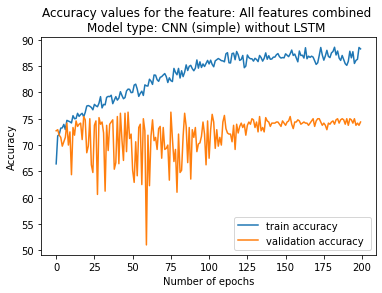

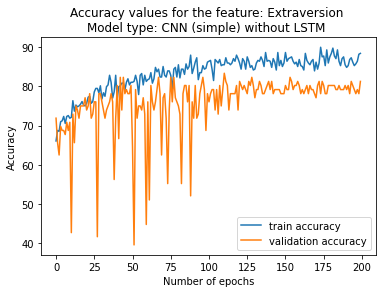

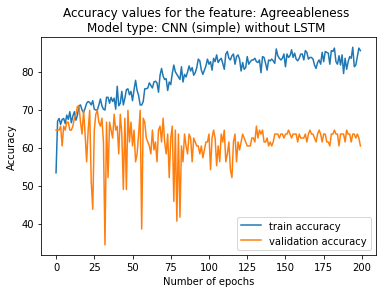

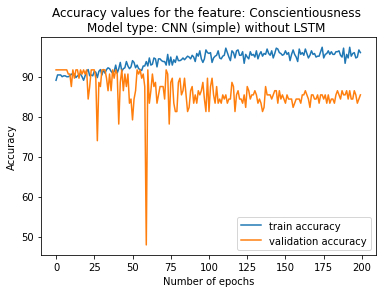

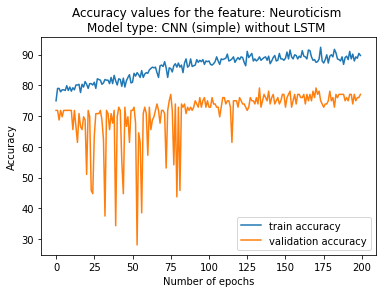

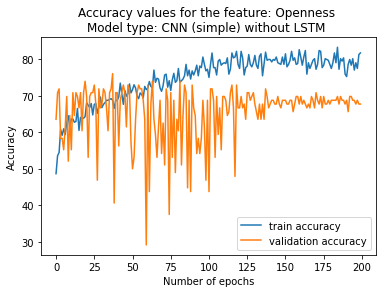

In [22]:
import matplotlib.pyplot as plt

model_type = "CNN (simple) without LSTM"

#features = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']

results_df = pd.read_csv("results_cnn_simple.csv", header = 0) # results_cnn

plt.plot(results_df['train_accuracy'], label="train accuracy")
plt.plot(results_df['validation_accuracy'], label="validation accuracy ")
plt.title(f"Accuracy values for the feature: All features combined \nModel type: {model_type} ") # cutoff = {cutoff}, 
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend()
plt.show()

for i in range(5):
    plt.plot(results_df['train_accuracy_' + str(features[i])], label="train accuracy")
    plt.plot(results_df['validation_accuracy_' + str(features[i])], label="validation accuracy")
    plt.title(f"Accuracy values for the feature: {str(features[i])} \nModel type: {model_type} ") # cutoff = {cutoff},
    plt.ylabel('Accuracy')
    plt.xlabel('Number of epochs')
    plt.legend()
    plt.show()

